Main notebook file

In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U dataretrieval

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import glob

import numpy as np
import rasterio
import xarray

import folium

import dataretrieval.nwis as nwis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Read in paradise climate data from [USDA Snotel](https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/679:WA:SNTL%7Cid=%22%22%7Cname/2012-01-01,2022-02-22/PREC::value,PRCPMTD::value,TAVG::value,TMIN::value,TMAX::value,SMS:-2:value,SMS:-4:value,SMS:-8:value,SMS:-20:value,SNDN::value,WTEQ::value,SNWD::value,SNRR::value?fitToScreen=false)

In [4]:
paradise_path = '/Users/ivanduse/Dropbox (University of Oregon)/gage-guesser/data/paradiseclimate.csv'

In [5]:
pclim = pd.read_csv(paradise_path)
pclim['Date'] = pd.to_datetime(pclim['Date'])
pclim = pclim.set_index(['Date'])
pclim = pclim.loc['2012-01-01':'2021-12-31']
pclim

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values,Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values
Date,,,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,32.7,32.3,37.8,36.6,42.8,24.4,57.0,38.0,NaN
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,32.2,32.0,37.6,36.5,41.9,24.7,59.0,300.0,NaN
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,32.0,31.9,37.4,36.3,42.2,25.3,60.0,100.0,NaN
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,31.7,31.5,37.4,36.3,43.1,25.4,59.0,143.0,NaN
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,31.7,31.8,37.5,36.3,44.0,26.4,60.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,20.2,22.6,33.8,34.1,23.9,24.9,104.0,0.0,NaN
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,20.1,22.6,33.8,34.1,24.2,24.9,103.0,67.0,NaN
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,20.2,22.5,33.8,34.1,24.9,25.1,101.0,100.0,NaN


In [13]:
pclim['Surface Soil Moisture'] = pclim['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values']
pclim['Depth Soil Moisture'] = (
                          pclim['Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values'])/4
df = pclim.drop(['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values',\
                'Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values'], axis=1)
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture
Date,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600


## Read in Discharge Data

In [14]:
# specify the USGS site code for which we want data.
nisqually = '12082500' #nisqually river
puyallup = '12092000' #puyallup basin
cowlitz = '14226500' #cowlitz basin


# get instantaneous values (iv)
nisDis = nwis.get_record(sites=nisqually, service='dv', start='2012-01-01', end='2021-12-31')
nisDis

,00020_Maximum,00020_Maximum_cd,site_no,00020_Minimum,00020_Minimum_cd,00020_Mean,00020_Mean_cd,00060_Mean,00060_Mean_cd,00065_Mean,00065_Mean_cd
datetime,,,,,,,,,,,
2012-01-01 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1220.0,A,6.41,A
2012-01-02 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.10,A
2012-01-03 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,900.0,A,5.92,A
2012-01-04 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,844.0,A,5.82,A
2012-01-05 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.09,A
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+00:00,-5.3,P,12082500,-8.6,P,-6.7,P,656.0,P,4.92,P
2021-12-28 00:00:00+00:00,-1.4,P,12082500,-5.6,P,-3.5,P,610.0,P,4.85,P
2021-12-29 00:00:00+00:00,-3.4,P,12082500,-5.7,P,-4.7,P,567.0,P,4.78,P


### Combine data frames

In [15]:
df['Nisqually Discharge'] = nisDis['00060_Mean'].values
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture,Nisqually Discharge
Date,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675,1220.0
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525,1010.0
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400,900.0
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300,844.0
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400,1010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625,656.0
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625,610.0
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600,567.0


In [20]:
#drop the NAN values
df.dropna(inplace=True)

# Create the most basic of all machine learning models

In [21]:
# Define feature list
feature_list =  df.columns.to_list()


In [22]:

# Define features and labels 
X = df[feature_list]
y = df['Nisqually Discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [23]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [25]:

# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

231.55646416292586

In [28]:
df['Nisqually Discharge'].max()

9920.0

(0.0, 10000.0)

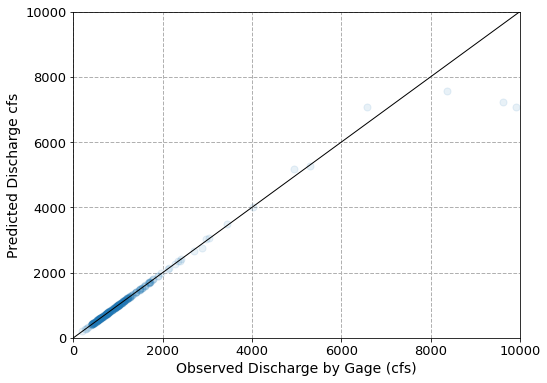

In [30]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

### SICK MAP

In [ ]:
nisqually_loc = 46.75260766, -122.0837194
paradise_loc = 46.78, -121.75
 

#### add in shapefile of the upstream basin and a centerline of our river...
[like this](https://waterdata.usgs.gov/monitoring-location/12082500/#parameterCode=00065&period=P7D)

In [ ]:
map = folium.Map(location=[nisqually_loc[0],nisqually_loc[1]], zoom_start=9)
folium.Marker(nisqually_loc, popup='Nisqually Gage').add_to(map)
folium.Marker(paradise_loc, popup='Paradise Snotel').add_to(map)
map